<a href="https://colab.research.google.com/github/sungjindo/Traffic-prediction/blob/main/Baseline_EDA_ver2%2BXGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 라이브러리 임포트
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.utils import data
from torch.optim import Adam
from google.colab import drive
import datetime as dt
from datetime import timedelta
import seaborn as sns

import xgboost as xgb

from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object

import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
DATASET_PATH = os.path.join('/content/gdrive/MyDrive/글창사 traffic/data')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)


In [ ]:
train = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))
val = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))
test = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))

def datesetting(train): 
    train['날짜1']=train['날짜'].astype(str)
    train['시간1']=train['시간'].astype(str)
    train['date']=train['날짜1']+train['시간1']

    for i in range (0,len(train['날짜'])):
      a= train['날짜1'][i]
      train['날짜1'][i] =dt.datetime.strptime(a, '%Y%m%d')

    for i in range(0,len(train['시간'])):
      b= train['시간1'][i]
      train['시간1'][i]=dt.datetime.strptime(b, '%H')

    for i in range(0,len(train['날짜'])):
      train['date'][i]=train['날짜1'][i]+timedelta(hours=train['시간1'][i].hour)


datesetting(train)
datesetting(val)
datesetting(test)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#hour/month/day data를 생성하여 추가
train=train.drop(['날짜1','시간1'],axis=1)
val=val.drop(['날짜1','시간1'],axis=1)
test=test.drop(['날짜1','시간1'],axis=1)


# index 설정하여 각 기간별 columns 생성하는 함수(create_features)
train=train.set_index('date')
val=val.set_index('date')
test=test.set_index('date')
test = test[test.index >= '2020-05-25']
df= pd.concat([train,val])
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    # df['weekofyear'] = df.index.isocalendar().week   UIint32 형으로 출력되어 삭제함.
    return df


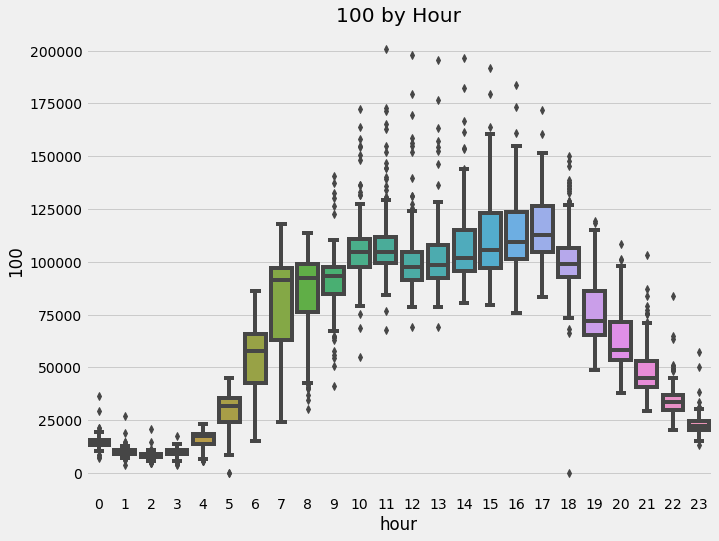

In [ ]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='100')
ax.set_title('100 by Hour')
plt.show()

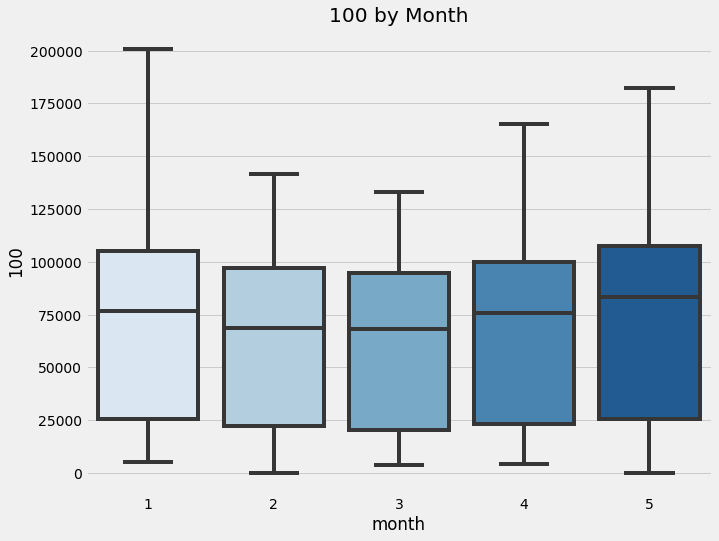

In [ ]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='100', palette= 'Blues')
ax.set_title('100 by Month')
plt.show()

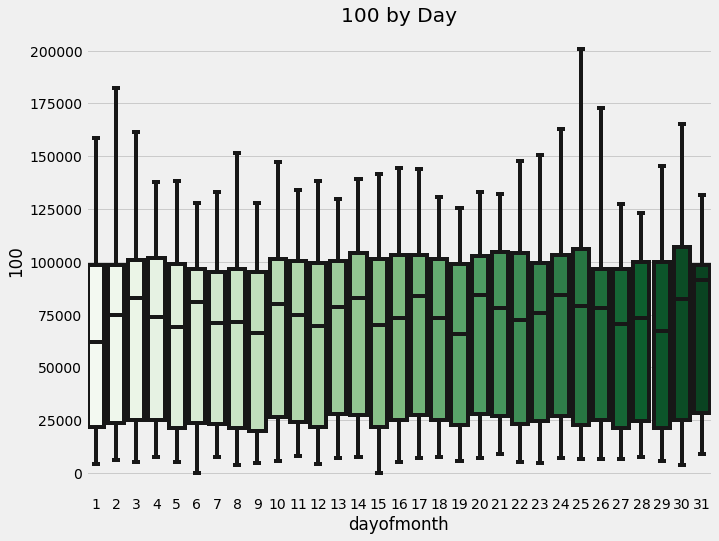

In [ ]:
fig,ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofmonth', y='100', palette= 'Greens')
ax.set_title('100 by Day')
plt.show()

#Creat the model


In [ ]:
df = create_features(df)
test = create_features(test)
val = create_features(val)

In [ ]:
#Feature와 Target을 설정해주는 함수 
#ex)'10'의 통행량을 예측하기 위해 나머지 Feature가 사용되는 구조

def makeF(i):
  FEATURES = df.drop(df.iloc[:,i].name, axis=1).columns.tolist()
  return FEATURES
def makeT(i):
  TARGET = df.iloc[:,i].name
  return TARGET

In [ ]:
def makeXGBoost(i):
  X_train = df[makeF(i)]
  y_train = df[makeT(i)]

  X_val = val[makeF(i)]
  y_val = val[makeT(i)]
  X_test = test[makeF(i)]
  y_test = test[makeT(i)]
  reg = xgb.XGBRegressor(n_estimators = 1000,early_stipping_rounds=50,
                        learning_rate = 0.01)
  reg.fit(X_train, y_train, 
          eval_set=[(X_train, y_train), (X_val,y_val)],
          verbose=100)
  test['prediction'] = reg.predict(X_test)
  return test

In [ ]:
makeXGBoost(2)

[09:13:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:259345	validation_1-rmse:260451
[100]	validation_0-rmse:96787.4	validation_1-rmse:91789.7
[200]	validation_0-rmse:37887.8	validation_1-rmse:31597.2
[300]	validation_0-rmse:17718.1	validation_1-rmse:12109
[400]	validation_0-rmse:11517.4	validation_1-rmse:8544.58
[500]	validation_0-rmse:9552.12	validation_1-rmse:7954.41
[600]	validation_0-rmse:8741.23	validation_1-rmse:7619.52
[700]	validation_0-rmse:8339.08	validation_1-rmse:7350.63
[800]	validation_0-rmse:8000.41	validation_1-rmse:7096.84
[900]	validation_0-rmse:7740.05	validation_1-rmse:6897.33
[999]	validation_0-rmse:7522.71	validation_1-rmse:6713.48


,날짜,시간,10,100,101,120,121,140,150,160,...,5510,6000,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,prediction
date,,,,,,,,,,,,,,,,,,,,,
2020-05-25 00:00:00,20200525,0,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,0,0,2,5,2020,146,25,13792.607422
2020-05-25 01:00:00,20200525,1,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,1,0,2,5,2020,146,25,13792.607422
2020-05-25 02:00:00,20200525,2,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,2,0,2,5,2020,146,25,13792.607422
2020-05-25 03:00:00,20200525,3,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,3,0,2,5,2020,146,25,13792.607422
2020-05-25 04:00:00,20200525,4,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,4,0,2,5,2020,146,25,12504.825195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-31 19:00:00,20200531,19,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,19,6,2,5,2020,152,31,12288.825195
2020-05-31 20:00:00,20200531,20,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,20,6,2,5,2020,152,31,13081.192383
2020-05-31 21:00:00,20200531,21,-999,-999,-999,-999,-999,-999,-999,-999,...,-999,-999,21,6,2,5,2020,152,31,17975.076172


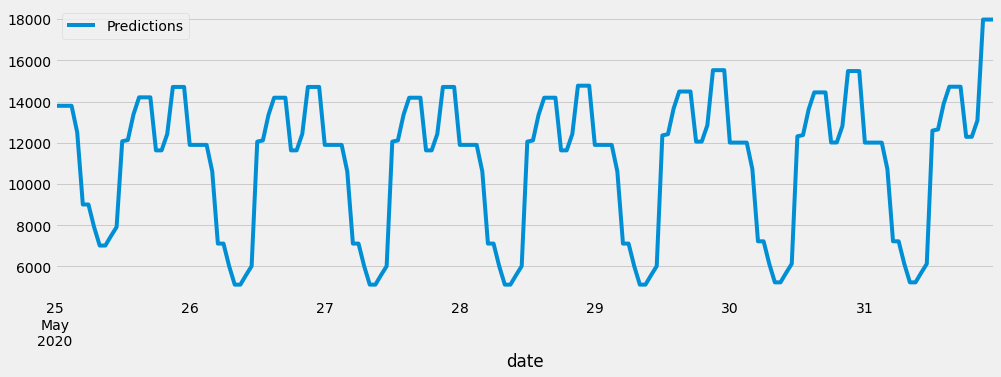

In [ ]:
test['prediction'].plot(figsize=(15,5))
plt.legend(['Predictions'])

plt.show()